# Imports + Cache Loader + Cycle Lists

In [ ]:
import os
import numpy as np
import pandas as pd
import requests
import pyreadstat

# Cache directory
CACHE_DIR = "nhanes_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# ---------------------------------------
# Helper: Load NHANES XPT with caching
# ---------------------------------------
def load_nhanes_xpt(filename: str, year: str):
    local_path = os.path.join(CACHE_DIR, f"{year}_{filename}")

    if os.path.exists(local_path):
        df, meta = pyreadstat.read_xport(local_path)
        return df

    url = f"https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/{year}/DataFiles/{filename}"
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if r.status_code == 404:
        print(f"Missing: {filename} for {year}")
        return None

    with open(local_path, "wb") as f:
        f.write(r.content)

    df, meta = pyreadstat.read_xport(local_path)
    return df


# ---------------------------------------
# Cycle file dictionaries (2011–2018)
# ---------------------------------------
def cycle(year, suffix):
    return {
        "DEMO":   f"DEMO_{suffix}.xpt",
        "HDL":    f"HDL_{suffix}.xpt",
        "TCHOL":  f"TCHOL_{suffix}.xpt",
        "TRIGLY": f"TRIGLY_{suffix}.xpt",
        "GLU":    f"GLU_{suffix}.xpt",
        "INS":    f"INS_{suffix}.xpt" if suffix != "G" else "GLU_G.xpt",
        "DPQ":    f"DPQ_{suffix}.xpt",
        "SLQ":    f"SLQ_{suffix}.xpt",
        "DR1TOT": f"DR1TOT_{suffix}.xpt",
        "PAQ":    f"PAQ_{suffix}.xpt",
        "BPX":    f"BPX_{suffix}.xpt",
        "BIOPRO": f"BIOPRO_{suffix}.xpt",      # ALT/AST in some cycles
        "ALB_CR": f"ALB_CR_{suffix}.xpt",
        "BMX":    f"BMX_{suffix}.xpt",          # BMI/waist
        "CBC":    f"CBC_{suffix}.xpt",
    }

all_cycles = {
    "2011": cycle("2011", "G"),
    "2013": cycle("2013", "H"),
    "2015": cycle("2015", "I"),
    "2017": cycle("2017", "J"),
}


# Merge NHANES Cycles

In [ ]:
def load_cycle(files: dict, year: str):
    dfs = []
    for name, fname in files.items():
        d = load_nhanes_xpt(fname, year)
        if d is not None:
            dfs.append(d)

    if not dfs:
        return None

    merged = dfs[0]
    for d in dfs[1:]:
        merged = merged.merge(d, on="SEQN", how="outer")

    merged["CYCLE"] = year
    return merged


df_list = []
for yr, files in all_cycles.items():
    print(f"Loading cycle {yr} ...")
    out = load_cycle(files, yr)
    if out is not None:
        df_list.append(out)

df_all = pd.concat(df_list, ignore_index=True)
print("Merged NHANES shape:", df_all.shape)


# Harmonization Functions

In [ ]:
# ----------------------------------
# Demographics
# ----------------------------------
def harmonize_demographics(df):
    out = df.copy()
    out["age"] = out.get("RIDAGEYR", np.nan)
    out["sex"] = out["RIAGENDR"].map({1: "Male", 2: "Female"}) if "RIAGENDR" in out else np.nan
    out["pir"] = out.get("INDFMPIR", np.nan)
    out["race_ethnicity"] = out.get("RIDRETH3", np.nan)
    return out


# ----------------------------------
# Blood Pressure
# ----------------------------------
def harmonize_bp(df):
    out = df.copy()
    sbp_cols = [c for c in out if c.startswith("BPXSY")]
    dbp_cols = [c for c in out if c.startswith("BPXDI")]

    out["sbp"] = out[sbp_cols].mean(axis=1) if sbp_cols else np.nan
    out["dbp"] = out[dbp_cols].mean(axis=1) if dbp_cols else np.nan
    out["pulse_pressure"] = out["sbp"] - out["dbp"]
    return out


# ----------------------------------
# Lipids
# ----------------------------------
def harmonize_lipids(df):
    out = df.copy()
    out["hdl"] = out.get("LBDHDD", np.nan)
    out["tc"]  = out.get("LBXTC", np.nan)
    out["tg"]  = out.get("LBXTR", np.nan)

    if "LBXTC" in out and "LBDHDD" in out:
        out["ldl"] = out["LBXTC"] - out["LBDHDD"] - (out["LBXTR"] / 5)
    else:
        out["ldl"] = np.nan

    out["apob_est"] = 0.65 * out["tc"] - 0.59 * out["hdl"]
    return out


# ----------------------------------
# Renal
# ----------------------------------
def harmonize_renal(df):
    out = df.copy()
    out["creat_mg_dl"] = out.get("LBXSCR", np.nan)
    out["egfr"] = 175 * (out["creat_mg_dl"] ** -1.154) * 1.018
    out["acr"] = out.get("URXUM", np.nan) / out.get("URXCRS", np.nan)
    return out


# ----------------------------------
# Metabolic
# ----------------------------------
def harmonize_metabolic(df):
    out = df.copy()
    out["glucose"] = out.get("LBXGLU", np.nan)
    out["insulin"] = out.get("LBXINS", np.nan)
    out["homa_ir"] = (out["glucose"] * out["insulin"]) / 405
    return out


# ----------------------------------
# Sleep
# ----------------------------------
def harmonize_sleep(df):
    out = df.copy()
    out["sleep_hours"] = out.get("SLD010H", np.nan)
    out["sleep_trouble"] = out.get("SLQ050", np.nan)
    return out


# ----------------------------------
# PHQ-9
# ----------------------------------
def harmonize_phq(df):
    out = df.copy()
    phq_cols = [c for c in out.columns if c.startswith("DPQ0")]
    if phq_cols:
        out["phq9"] = out[phq_cols].sum(axis=1)
    else:
        out["phq9"] = np.nan
    return out


# ----------------------------------
# PA days + index
# ----------------------------------
def harmonize_physical_activity_days(df):
    out = df.copy()
    out["pa_vigorous_days"] = out.get("PAQ650", np.nan)
    out["pa_moderate_days"] = out.get("PAQ665", np.nan)
    out["pa_walk_days"]     = out.get("PAQ670", np.nan)

    out["pa_index"] = (
        2*out["pa_vigorous_days"]
        + out["pa_moderate_days"]
        + 0.5*out["pa_walk_days"]
    )
    return out


# ----------------------------------
# Diet (food groups)
# ----------------------------------
def harmonize_diet(df):
    out = df.copy()
    diet_map = {
        "whole_grains": "DR1TWHL",
        "refined_grains": "DR1TGR",
        "nuts_seeds": "DR1TNS",
        "legumes": "DR1TLEG",
        "low_fat_dairy": "DR1TDLF",
        "fish": "DR1TFISH",
        "red_meat": "DR1TREDM",
        "processed_meat": "DR1TPRM",
        "other_fruit": "DR1TFRT",
        "citrus_melons_berries": "DR1TCITM",
        "dark_green_veg": "DR1TVEG1",
        "other_veg": "DR1TVEG2",
        "ssb": "DR1TSSB",
        "fried_foods": "DR1TFF",
    }
    for new, old in diet_map.items():
        out[new] = out.get(old, np.nan)
    return out


# ----------------------------------
# BMI + waist
# ----------------------------------
def harmonize_additional(df):
    out = df.copy()
    out["bmi"]   = out.get("BMXBMI", np.nan)
    out["waist"] = out.get("BMXWAIST", np.nan)
    return out


# ----------------------------------
# ALT / AST + CBC
# ----------------------------------
def harmonize_liver_and_cbc(df):
    out = df.copy()

    # ALT
    for col in ["LBXALT","LBDALT","LBDALTSI","LBXSAT","LBXSATSI","LBXSAPSI"]:
        if col in out:
            out["alt"] = out[col]
            break
    else:
        out["alt"] = np.nan

    # AST
    for col in ["LBXAST","LBDAST","LBDASSI","LBXSAS","LBXSASSI"]:
        if col in out:
            out["ast"] = out[col]
            break
    else:
        out["ast"] = np.nan

    # Hemoglobin
    out["hemoglobin"] = out.get("LBXHGB", np.nan)

    # WBC
    out["wbc"] = out.get("LBXWBCSI", out.get("LBXWBC", np.nan))

    # Platelets
    out["platelets"] = out.get("LBXPLTSI", out.get("LBXPLT", np.nan))

    return out


# Master Harmonization Pipeline

In [ ]:
def prepare_nhanes(df):
    return (
        df
        .pipe(harmonize_demographics)
        .pipe(harmonize_bp)
        .pipe(harmonize_lipids)
        .pipe(harmonize_renal)
        .pipe(harmonize_metabolic)
        .pipe(harmonize_sleep)
        .pipe(harmonize_phq)
        .pipe(harmonize_physical_activity_days)
        .pipe(harmonize_diet)
        .pipe(harmonize_liver_and_cbc)
        .pipe(harmonize_additional)
    )

df_h = prepare_nhanes(df_all)
print(df_h.shape)

df_h[["bmi","waist","alt","ast","wbc","hemoglobin","platelets"]].notna().mean()


# Variable-level GGM (Biovista backbone)

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso

# -------------------------------------------------------
# 1. Define system → variable map for variable-level GGM
# -------------------------------------------------------
physio_systems_ggm = {
    "Demographics": ["age", "pir"],

    "Lipids": ["hdl", "tc", "tg", "ldl", "apob_est"],

    "Metabolic": [
        "glucose", "insulin", "homa_ir",
        "bmi", "waist"
    ],

    "Blood_Pressure": ["sbp", "dbp", "pulse_pressure"],

    "Renal": ["creat_mg_dl", "egfr", "acr"],

    "Liver": ["alt", "ast"],

    "Inflammation": ["wbc"],

    "Hematologic": ["hemoglobin", "platelets"],

    "Sleep": ["sleep_hours", "sleep_trouble"],

    "Mental_Health": ["phq9"],

    "Physical_Activity": [
        "pa_vigorous_days", "pa_moderate_days",
        "pa_walk_days", "pa_index"
    ],

    "Diet": [
        "whole_grains", "refined_grains", "nuts_seeds", "legumes",
        "low_fat_dairy", "fish", "red_meat", "processed_meat",
        "other_fruit", "citrus_melons_berries", "dark_green_veg",
        "other_veg", "ssb", "fried_foods"
    ],
}

# -------------------------------------------------------
# 2. Flatten & filter by missingness ≥ 40%
# -------------------------------------------------------
all_vars = sum(physio_systems_ggm.values(), [])
all_vars = [v for v in all_vars if v in df_h.columns]

nonmissing_frac = df_h[all_vars].notna().mean()
vars_use = nonmissing_frac[nonmissing_frac >= 0.40].index.tolist()

print("Variables used in variable-level GGM:", len(vars_use))
print(vars_use)

# -------------------------------------------------------
# 3. Impute + standardize
# -------------------------------------------------------
X = df_h[vars_use].to_numpy(float)

imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# -------------------------------------------------------
# 4. Fit Graphical Lasso
# -------------------------------------------------------
ggm_model = GraphicalLasso(alpha=0.15, max_iter=200)
ggm_model.fit(X_std)

precision = ggm_model.precision_.copy()

# Partial correlations
diag = np.sqrt(np.diag(precision))
outer = np.outer(diag, diag)
partial_corr = -precision / outer
np.fill_diagonal(partial_corr, 0.0)

# -------------------------------------------------------
# 5. Build NetworkX graph
# -------------------------------------------------------
G_var = nx.Graph()

# Map variable → system
var_to_system = {}
for system, var_list in physio_systems_ggm.items():
    for v in var_list:
        if v in vars_use:
            var_to_system[v] = system

# Add nodes
for v in vars_use:
    G_var.add_node(v, system=var_to_system.get(v, "Other"))

# Add edges with small threshold
edge_threshold = 0.10
for i, vi in enumerate(vars_use):
    for j in range(i + 1, len(vars_use)):
        vj = vars_use[j]
        w = partial_corr[i, j]
        if abs(w) >= edge_threshold:
            G_var.add_edge(vi, vj, weight=w)

print(f"Variable-level GGM: {G_var.number_of_nodes()} nodes, {G_var.number_of_edges()} edges")

# -------------------------------------------------------
# 6. Layout for consistent plotting
# -------------------------------------------------------
pos_var = nx.spring_layout(G_var, seed=1, k=0.35)


# Create a simulated “interesting” patient

In [ ]:
# -------------------------------------------------------
# 1. Population mean & SD for these variables
# -------------------------------------------------------
df_desc = df_h[vars_use].describe()
mu = df_desc.loc["mean"]
sd = df_desc.loc["std"].replace(0, np.nan)   # guard against divide-by-zero

# Start at mean
patient_vals = mu.copy()

# -------------------------------------------------------
# 2. Make an "interesting" patient (abnormal in several systems)
#    (You can tweak these z-values to taste.)
# -------------------------------------------------------
z_overrides = {
    # Lipids / metabolic
    "apob_est": +2.0,
    "hdl": -1.5,
    "tg": +2.0,
    "glucose": +2.0,
    "insulin": +2.0,
    "homa_ir": +2.5,
    "bmi": +2.0,
    "waist": +2.0,

    # BP
    "sbp": +1.5,
    "dbp": +1.0,

    # Renal
    "egfr": -1.0,
    "acr": +1.5,

    # Liver
    "alt": +2.0,
    "ast": +1.5,

    # Inflammation / hematology
    "wbc": +1.5,
    "hemoglobin": -1.0,
    "platelets": +1.0,

    # Sleep / mental health
    "sleep_hours": -1.5,
    "sleep_trouble": +1.5,
    "phq9": +2.0,

    # Physical activity
    "pa_index": -2.0,

    # Diet (if present)
    "whole_grains": -1.0,
    "red_meat": +1.5,
    "ssb": +2.0,

    # Demographics
    "age": +1.0,
    "pir": -1.0,
}

for var, z in z_overrides.items():
    if var in patient_vals.index and pd.notna(sd[var]):
        patient_vals[var] = mu[var] + z * sd[var]

# -------------------------------------------------------
# 3. Variable-level z-scores for this patient
# -------------------------------------------------------
z_patient = (patient_vals - mu) / sd
z_patient = z_patient.fillna(0.0)

z_patient.head()


# Plot Biovista-style variable-level network

In [ ]:
# -------------------------------------------------------
# Pretty plotting function (variable-level Biovista)
# -------------------------------------------------------
system_color_map = {
    "Demographics": "#008080",
    "Lipids": "#f1c40f",
    "Metabolic": "#e67e22",
    "Blood_Pressure": "#e74c3c",
    "Renal": "#8e44ad",
    "Liver": "#d35400",
    "Inflammation": "#c0392b",
    "Hematologic": "#7f8c8d",
    "Sleep": "#3498db",
    "Mental_Health": "#2c3e50",
    "Physical_Activity": "#27ae60",
    "Diet": "#16a085",
    "Other": "#7f8c8d",
}

def plot_biovista_patient_network(
    G,
    z_scores,
    var_to_system,
    pos,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
):
    # Attach z-scores + system labels
    for n in G.nodes():
        G.nodes[n]["z"] = float(z_scores.get(n, 0.0))
        G.nodes[n]["system"] = var_to_system.get(n, "Other")

    z_vals = np.array([G.nodes[n]["z"] for n in G.nodes()])
    z_clipped = np.clip(z_vals, -3, +3)

    # Color by z-score
    cmap = plt.cm.coolwarm
    node_colors = cmap((z_clipped + 3) / 6)

    # Size by |z|
    node_sizes = 250 + 600 * np.abs(z_clipped)

    # Edge widths by |weight|
    edge_widths = [
        0.4 + 3.0 * abs(d.get("weight", 0.05))
        for (_, _, d) in G.edges(data=True)
    ]

    # Node outlines by system
    node_edgecolors = [
        system_color_map.get(G.nodes[n]["system"], "#7f8c8d")
        for n in G.nodes()
    ]

    fig, ax = plt.subplots(figsize=(12, 12))

    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        alpha=0.25,
        ax=ax
    )

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.2,
        ax=ax
    )

    nx.draw_networkx_labels(
        G, pos,
        font_size=7,
        font_weight="bold",
        ax=ax
    )

    # Colorbar for z-score
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=-3, vmax=3)
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Z-score (patient vs NHANES)")

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()
    fig.savefig(out_file, dpi=350, bbox_inches="tight")
    plt.show()

    return fig, ax

# -------------------------------------------------------
# 8. Generate and save the figure
# -------------------------------------------------------
fig, ax = plot_biovista_patient_network(
    G_var,
    z_patient,
    var_to_system,
    pos_var,
    title="Biovista Variable-Level Network (NHANES Simulation)",
    out_file="biovista_variable_patient_network.png"
)

print("Saved: biovista_variable_patient_network.png")


In [ ]:
# -------------------------------------------------------
# Side-by-side comparison: Healthy vs Unhealthy
# -------------------------------------------------------


# -------------------------------------------------------
# Side-by-side comparison: Michael vs Daniel
# -------------------------------------------------------

# 1. Michael (Healthy) — baseline, all z = 0
z_Michael = pd.Series(0.0, index=z_patient.index)

# 2. Daniel (Unhealthy) — your simulated patient with abnormalities
z_Daniel = z_patient.copy()


# -------------------------------------------------------
# Shared layout (identical coordinates for both)
# -------------------------------------------------------
pos_shared = pos_var


# -------------------------------------------------------
# Helper function (your original code, unchanged)
# -------------------------------------------------------
def plot_biovista_on_axes(G, z_scores, ax, title):
    # Attach z-scores and metadata to nodes for plotting
    for n in G.nodes():
        G.nodes[n]["z"] = float(z_scores.get(n, 0.0))
        G.nodes[n]["system"] = var_to_system.get(n, "Other")

    z_vals = np.array([G.nodes[n]["z"] for n in G.nodes()])
    z_clip = np.clip(z_vals, -3, 3)

    node_colors = plt.cm.coolwarm((z_clip + 3) / 6)
    node_sizes = 250 + 600 * np.abs(z_clip)
    node_edgecolors = [
        system_color_map.get(G.nodes[n]["system"], "#7f8c8d") 
        for n in G.nodes()
    ]
    edge_widths = [
        0.4 + 3 * abs(d.get("weight", 0.05))
        for (_, _, d) in G.edges(data=True)
    ]

    nx.draw_networkx_edges(G, pos_shared, width=edge_widths, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(
        G, pos_shared,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.2,
        ax=ax
    )
    nx.draw_networkx_labels(
        G, pos_shared,
        font_size=7,
        font_weight="bold",
        ax=ax
    )

    ax.set_title(title)
    ax.axis("off")


# -------------------------------------------------------
# Final side-by-side figure
# -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plot_biovista_on_axes(G_var, z_Michael, axes[0], "Michael — Healthy Network (Z = 0)")
plot_biovista_on_axes(G_var, z_Daniel, axes[1], "Daniel — Multi-System Dysregulation")

plt.tight_layout()
plt.savefig("biovista_michael_vs_daniel.png", dpi=350, bbox_inches="tight")
plt.show()

print("Saved: biovista_michael_vs_daniel.png")


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_biovista_patient_network_labeled(
    G,
    z_scores,
    var_to_system,
    pos,
    title,
    ax
):
    """
    Draws the patient network onto a provided matplotlib axis.
    """

    # Attach metadata
    for n in G.nodes():
        G.nodes[n]["z"] = float(z_scores.get(n, 0.0))
        G.nodes[n]["system"] = var_to_system.get(n, "Other")

    z_vals = np.array([G.nodes[n]["z"] for n in G.nodes()])
    z_clipped = np.clip(z_vals, -3, 3)

    # Color by z-score
    cmap = plt.cm.coolwarm
    node_colors = cmap((z_clipped + 3) / 6)

    # Size by |z|
    node_sizes = 250 + 600 * np.abs(z_clipped)

    # Edge widths
    edge_widths = [
        0.4 + 3.0 * abs(d.get("weight", 0.05))
        for (_, _, d) in G.edges(data=True)
    ]

    # Node outlines by system
    system_color_map = {
        "Demographics": "#008080",
        "Lipids": "#f1c40f",
        "Metabolic": "#e67e22",
        "Blood_Pressure": "#e74c3c",
        "Renal": "#8e44ad",
        "Sleep": "#3498db",
        "Mental_Health": "#2c3e50",
        "Physical_Activity": "#27ae60",
        "Diet": "#16a085",
        "Other": "#7f8c8d",
    }

    node_edgecolors = [
        system_color_map.get(G.nodes[n]["system"], "#7f8c8d")
        for n in G.nodes()
    ]

    # --- Drawing ---
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        alpha=0.25,
        ax=ax
    )
    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.2,
        ax=ax
    )
    nx.draw_networkx_labels(
        G, pos,
        font_size=6.5,
        font_weight="bold",
        ax=ax
    )

    ax.set_title(title, fontsize=14)
    ax.axis("off")

# ---------------------------------------------------------
#  FINAL SIDE-BY-SIDE FIGURE
# ---------------------------------------------------------

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

plot_biovista_patient_network_labeled(
    G_var,
    z_Michael,          # your healthy z-score vector
    var_to_system,
    pos_var,
    title="Michael — Healthy, Stable Network",
    ax=axes[0]
)

plot_biovista_patient_network_labeled(
    G_var,
    z_Daniel,           # your unhealthy z-score vector
    var_to_system,
    pos_var,
    title="Daniel — Multi-System Dysregulation",
    ax=axes[1]
)

plt.tight_layout()
plt.savefig("biovista_michael_vs_daniel.png", dpi=350)
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# -------------------------------------------------------
# 1. Compute node degree for the variable-level graph
# -------------------------------------------------------
degree_dict = dict(G_var.degree())

# Convert to a pandas Series for alignment
degree_series = pd.Series(degree_dict)

# Keep only variables we model
degree_series = degree_series.loc[z_patient.index]

# To avoid zero-degree division issues, add a small epsilon
degree_series = degree_series.replace(0, 0.5)


# -------------------------------------------------------
# 2. Define the z-score vectors for each person
# -------------------------------------------------------

# Michael = healthy prototype → all zeros
z_michael = pd.Series(0.0, index=z_patient.index)

# Daniel = simulated unhealthy patient you created earlier
z_daniel = z_patient.copy()


# -------------------------------------------------------
# 3. Network score formula
# -------------------------------------------------------
# Weighted absolute z-scores: |z| * degree
def compute_network_score(z_vec, degree_vec):
    weighted = np.abs(z_vec) * degree_vec
    return weighted.sum()

network_score_michael = compute_network_score(z_michael, degree_series)
network_score_daniel = compute_network_score(z_daniel, degree_series)


# -------------------------------------------------------
# 4. Output comparison table
# -------------------------------------------------------
df_scores = pd.DataFrame({
    "Network Score": [network_score_michael, network_score_daniel]
}, index=["Michael (Healthy)", "Daniel (Unhealthy)"])

print(df_scores)


In [ ]:
# code to render plots separately
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# ----------------------------
# Helper function
# ----------------------------
def plot_single_biovista(
    G,
    z_scores,
    var_to_system,
    pos,
    title,
    out_file
):
    Gp = G.copy()

    # Assign z-scores
    for n in Gp.nodes():
        Gp.nodes[n]["z"] = float(z_scores.get(n, 0.0))
        Gp.nodes[n]["system"] = var_to_system.get(n, "Other")

    # Extract z
    z_vals = np.array([Gp.nodes[n]["z"] for n in Gp.nodes()])
    z_clip = np.clip(z_vals, -3, 3)

    cmap = plt.cm.coolwarm
    node_colors = cmap((z_clip + 3) / 6)
    node_sizes = 250 + 600 * np.abs(z_clip)
    node_edgecolors = [
        system_color_map.get(Gp.nodes[n]["system"], "#7f8c8d")
        for n in Gp.nodes()
    ]

    edge_widths = [0.4 + 3*abs(d.get("weight", 0.05))
                   for (_,_,d) in Gp.edges(data=True)]

    fig, ax = plt.subplots(figsize=(12,12))

    nx.draw_networkx_edges(Gp, pos, width=edge_widths, alpha=0.25, ax=ax)
    nx.draw_networkx_nodes(
        Gp, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edgecolors=node_edgecolors,
        linewidths=1.2,
        ax=ax
    )
    nx.draw_networkx_labels(Gp, pos, font_size=7, font_weight="bold", ax=ax)

    # Color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-3, vmax=3))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Z-score")

    ax.set_title(title)
    ax.axis("off")
    plt.tight_layout()

    plt.savefig(out_file, dpi=350, bbox_inches="tight")
    plt.show()

    print(f"Saved: {out_file}")


# ------------------------------------------
# Michael = healthy (all z = 0)
# ------------------------------------------
z_michael = pd.Series(0.0, index=z_patient.index)

plot_single_biovista(
    G_var,
    z_michael,
    var_to_system,
    pos_var,
    title="Biovista Profile — Michael (Healthy)",
    out_file="biovista_michael.png"
)

# ------------------------------------------
# Daniel = unhealthy (your simulated patient)
# ------------------------------------------
z_daniel = z_patient.copy()

plot_single_biovista(
    G_var,
    z_daniel,
    var_to_system,
    pos_var,
    title="Biovista Profile — Daniel (Unhealthy)",
    out_file="biovista_daniel.png"
)


In [ ]:
# Use the exact layout already computed for G_var
pos = pos_var  # previously computed spring_layout

G_empty = nx.Graph()
for v in vars_use:
    G_empty.add_node(v)

plt.figure(figsize=(12, 12))

nx.draw_networkx_nodes(
    G_empty,
    pos,
    node_size=600,
    node_color="#cccccc",
    edgecolors="black",
    linewidths=0.8
)

nx.draw_networkx_labels(
    G_empty,
    pos,
    font_size=8,
    font_weight="bold"
)

plt.title("Biovista: Raw Biomarker Universe")
plt.axis("off")
plt.tight_layout()
plt.savefig("biovista_nodes_only_same_layout.png", dpi=350)
plt.show()

print("Saved: biovista_nodes_only_same_layout.png")


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# ----------------------------------------------------
# 1. Build empty node-only graph with same nodes
# ----------------------------------------------------
G_empty = nx.Graph()
for v in G_var.nodes():
    G_empty.add_node(v)

# ----------------------------------------------------
# 2. Side-by-side plotting
# ----------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(22, 11))

# ----------------------------------------------------
# LEFT PLOT — Unconnected nodes ("Before Biovista")
# ----------------------------------------------------
nx.draw_networkx_nodes(
    G_empty,
    pos_var,
    node_size=600,
    node_color="#bfbfbf",
    edgecolors="black",
    linewidths=0.8,
    ax=axes[0]
)

nx.draw_networkx_labels(
    G_empty,
    pos_var,
    font_size=7,
    font_weight="bold",
    ax=axes[0]
)

axes[0].set_title("Before Biovista: Biomarkers Without Connections", fontsize=16)
axes[0].axis("off")

# ----------------------------------------------------
# RIGHT PLOT — Full Biovista network ("After Biovista")
# ----------------------------------------------------

# Node colors based on z-scores
z_vals = np.array([z_patient.get(n, 0.0) for n in G_var.nodes()])
z_clipped = np.clip(z_vals, -3, 3)
node_colors = plt.cm.coolwarm((z_clipped + 3) / 6)
node_sizes = 250 + 600 * np.abs(z_clipped)

# Node outline colors based on system membership
node_edgecolors = [
    system_color_map.get(G_var.nodes[n]["system"], "#7f8c8d")
    for n in G_var.nodes()
]

# Edge widths scaled by partial correlation strength
edge_widths = [
    0.4 + 3.0 * abs(d.get("weight", 0.05))
    for (_, _, d) in G_var.edges(data=True)
]

nx.draw_networkx_edges(
    G_var,
    pos_var,
    width=edge_widths,
    alpha=0.30,
    ax=axes[1]
)

nx.draw_networkx_nodes(
    G_var,
    pos_var,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors=node_edgecolors,
    linewidths=1.2,
    ax=axes[1]
)

nx.draw_networkx_labels(
    G_var,
    pos_var,
    font_size=7,
    font_weight="bold",
    ax=axes[1]
)

axes[1].set_title("After Biovista: Connected Physiologic Network", fontsize=16)
axes[1].axis("off")

plt.tight_layout()
plt.savefig("biovista_before_after_side_by_side.png", dpi=350, bbox_inches="tight")
plt.show()


# SCI pipeline

## NHANES Reference (df_ref)

In [90]:
import numpy as np
import pandas as pd
import itertools

def build_domain_reference_table(partial_corr, var_to_system):
    """
    Build NHANES domain-domain reference table with safe sigma handling.
    Ensures sigma > 0 and never produces degrees-of-freedom warnings.
    """

    variables = list(var_to_system.keys())
    systems = sorted(set(var_to_system.values()))

    # Convert partial correlation matrix to DataFrame with labels
    df_pc = pd.DataFrame(partial_corr, index=variables, columns=variables)

    # All distinct system pairs
    pairs = list(itertools.combinations(systems, 2))

    rows = []

    for A, B in pairs:
        weights = []

        # Collect all variable-to-variable partial correlations linking A ↔ B
        for i, j in itertools.combinations(variables, 2):
            if {var_to_system[i], var_to_system[j]} == {A, B}:
                weights.append(abs(df_pc.loc[i, j]))

        n = len(weights)

        # --- Safe mean/sigma handling ---
        if n >= 2:
            mu = float(np.mean(weights))
            sigma = float(np.std(weights, ddof=1))   # unbiased estimate
        elif n == 1:
            mu = float(weights[0])
            sigma = 1e-6      # safe tiny variance
        else:
            mu = 0.0
            sigma = 1e-6      # no information → tiny variance placeholder

        rows.append({
            "system_A": A,
            "system_B": B,
            "mu": mu,
            "sigma": sigma
        })

    return pd.DataFrame(rows)


## patient edges 
This ensures the patient network keeps NHANES topology but modulates by physiology.

In [92]:
def build_patient_edges_blended(z_vals, partial_corr, blend=0.5):
    variables = list(z_vals.index)
    df_pc = pd.DataFrame(partial_corr, index=variables, columns=variables)

    rows = []
    for i, j in itertools.combinations(variables, 2):
        rho = abs(df_pc.loc[i, j])
        mod = np.tanh(abs(z_vals[i] * z_vals[j]))
        w = blend * rho + (1 - blend) * mod
        rows.append({'i': i, 'j': j, 'weight': w})
    return pd.DataFrame(rows)


In [93]:
## final SCI_v20

In [94]:
def compute_SCI_v20(edges, node_system, df_ref, D_max=100, z_cap=10):
    import numpy as np
    import pandas as pd
    import itertools

    systems = sorted(set(node_system.values()))
    pairs = [(a,b) for a,b in itertools.combinations(systems,2)]

    # ---- Domain pairs table ----
    rows = []
    for A,B in pairs:
        mask = edges.apply(
            lambda r: ((node_system[r['i']] == A and node_system[r['j']] == B) or
                       (node_system[r['i']] == B and node_system[r['j']] == A)),
            axis=1
        )
        w = edges.loc[mask, 'weight'].abs()
        W_AB = w.mean() if len(w) else 0.0
        rows.append({"system_A":A, "system_B":B, "W_patient":W_AB})

    df = pd.DataFrame(rows).merge(df_ref, on=["system_A","system_B"], how="left")

    # ---- Stabilize sigma ----
    median_sigma = df_ref[df_ref["sigma"]>0]["sigma"].median()
    df["sigma_eff"] = df["sigma"].replace(0, median_sigma).fillna(median_sigma)

    # ---- Compute clipped z ----
    df["z_AB"] = ((df["W_patient"] - df["mu"]) / df["sigma_eff"]).clip(-z_cap, z_cap)

    # ---- Robust deviation ----
    df["z2"] = df["z_AB"]**2
    D = float(df["z2"].median())

    # ---- SCI mapping ----
    SCI_raw = 1 - min(1.0, np.sqrt(D) / np.sqrt(D_max))
    SCI = 100 * SCI_raw

    return SCI, {
        "D": D,
        "SCI_raw": SCI_raw,
        "SCI": SCI,
        "df_domain_pairs": df
    }


In [ ]:
## compute Dmax once and save it

In [95]:
# load

D_max = float(np.load("D_max_calibrated.npy"))


## compute SCI for any patient

In [96]:
edges_michael = build_patient_edges_blended(z_Michael, partial_corr, blend=0.5)
SCI_m, det_m = compute_SCI_v20(edges_michael, var_to_system, df_ref, D_max)

edges_daniel = build_patient_edges_blended(z_Daniel, partial_corr, blend=0.5)
SCI_d, det_d = compute_SCI_v20(edges_daniel, var_to_system, df_ref, D_max)


## domain heatmap

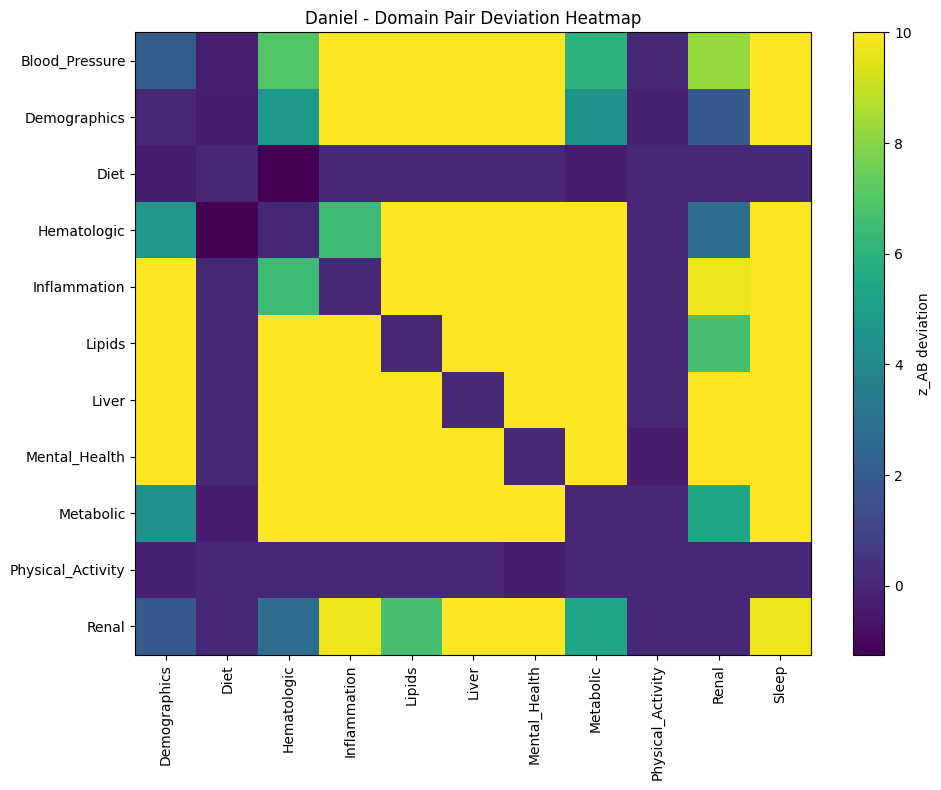

In [102]:
df_dp = det_d["df_domain_pairs"]

mat = df_dp.pivot(index="system_A", columns="system_B", values="z_AB")
mat = mat.copy()

# Symmetrize & fill diagonal
for i in mat.index:
    for j in mat.columns:
        if pd.isna(mat.loc[i,j]) and not pd.isna(mat.loc[j,i]):
            mat.loc[i,j] = mat.loc[j,i]
        if i == j:
            mat.loc[i,j] = 0

plt.figure(figsize=(10,8))
plt.imshow(mat, aspect='auto')
plt.xticks(range(len(mat.columns)), mat.columns, rotation=90)
plt.yticks(range(len(mat.index)), mat.index)
plt.title("Daniel - Domain Pair Deviation Heatmap")
plt.colorbar(label="z_AB deviation")
plt.tight_layout()
# Save figure
plt.savefig("heatmap_daniel.png", dpi=300, bbox_inches="tight")

plt.show()



In [ ]:
# Michael's heatmap (healthy)

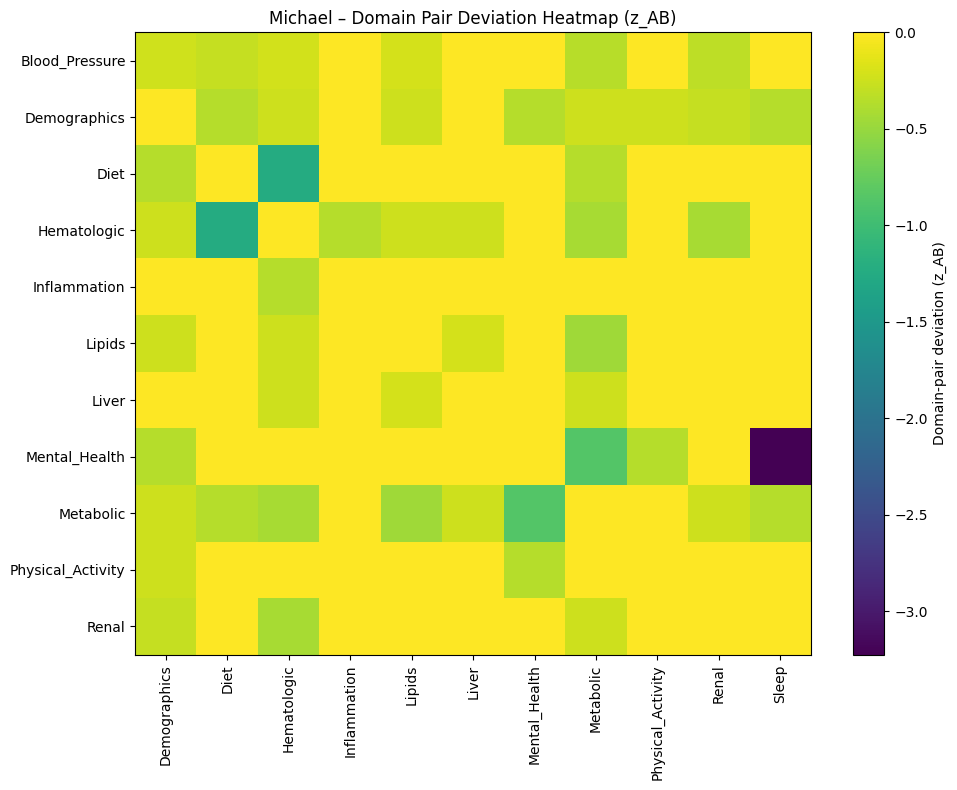

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Compute Michael’s domain-pair table
edges_michael = build_patient_edges_blended(z_Michael, partial_corr, blend=0.5)

SCI_m, det_m = compute_SCI_v20(
    edges=edges_michael,
    node_system=var_to_system,
    df_ref=df_ref,
    D_max=D_max    # your calibrated value
)

df_dp_m = det_m["df_domain_pairs"]

# 2. Pivot into matrix
mat_m = df_dp_m.pivot(index="system_A",
                      columns="system_B",
                      values="z_AB")

# 3. Make symmetric & fill diagonal
mat_m = mat_m.copy()
for i in mat_m.index:
    for j in mat_m.columns:
        if pd.isna(mat_m.loc[i,j]) and not pd.isna(mat_m.loc[j,i]):
            mat_m.loc[i,j] = mat_m.loc[j,i]
        if i == j:
            mat_m.loc[i,j] = 0

# 4. Plot heatmap
plt.figure(figsize=(10,8))
plt.imshow(mat_m, aspect='auto')   # allowed default colormap
plt.xticks(range(len(mat_m.columns)), mat_m.columns, rotation=90)
plt.yticks(range(len(mat_m.index)), mat_m.index)
plt.title("Michael – Domain Pair Deviation Heatmap (z_AB)")
plt.colorbar(label="Domain-pair deviation (z_AB)")
plt.tight_layout()

# 5. Save figure
plt.savefig("heatmap_michael.png", dpi=300, bbox_inches="tight")

plt.show()


In [104]:
# ---------------------------------------------
# 1. Build edges for each patient
# ---------------------------------------------
edges_michael = build_patient_edges_blended(
    z_Michael,
    partial_corr,
    blend=0.5
)

edges_daniel = build_patient_edges_blended(
    z_Daniel,
    partial_corr,
    blend=0.5
)

# ---------------------------------------------
# 2. Compute SCI v2.0 (using your calibrated D_max)
# ---------------------------------------------
SCI_michael, details_michael = compute_SCI_v20(
    edges=edges_michael,
    node_system=var_to_system,
    df_ref=df_ref,
    D_max=D_max          # D_max = 100 or your saved calibrated value
)

SCI_daniel, details_daniel = compute_SCI_v20(
    edges=edges_daniel,
    node_system=var_to_system,
    df_ref=df_ref,
    D_max=D_max
)

# ---------------------------------------------
# 3. Print results
# ---------------------------------------------
print("=== MICHAEL ===")
print("SCI_v2.0:", SCI_michael)
print("D:", details_michael['D'])

print("\n=== DANIEL ===")
print("SCI_v2.0:", SCI_daniel)
print("D:", details_daniel['D'])


=== MICHAEL ===
SCI_v2.0: 100.0
D: 0.0

=== DANIEL ===
SCI_v2.0: 3.0710153369987836
D: 93.95228067800326
